In [32]:
import os
import argparse
import numpy as np
from os import path as osp
from torch.utils import data
from torchvision import transforms
from PIL import Image
import numpy as np
import torch
from torch import nn
from torch import optim
from torch.optim.lr_scheduler import MultiStepLR
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision import datasets, models, transforms
from dataset.lip import LIPWithClass, LIP, LIPWithClass_Binary, LIP_Binary
from net.pspnet import PSPNet
from torchinfo import summary
from torchview import draw_graph
import timm
import matplotlib.pyplot as plt
import matplotlib
from torch.nn import functional as F

In [33]:
class PSPNetReID(nn.Module):
    def __init__(self ,pretrained=True):
        super().__init__()
        model = PSPNet(sizes=(1, 2, 3, 6), psp_size=1024, deep_features_size=512, backend='densenet')
        if pretrained == True:
            model.load_state_dict(torch.load('parsing.pth'))
        self.model = model
    def forward(self, x):
        with torch.inference_mode():
            x, _= self.model(x) 
            f = F.interpolate(input=x, size=(40, 40), mode='bilinear', align_corners=False)
        return f

In [34]:
model = PSPNetReID()
summary(model=model, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

/home/jun/miniconda3/envs/py311/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/jun/miniconda3/envs/py311/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
PSPNetReID (PSPNetReID)                            [32, 3, 224, 224]    [32, 2, 40, 40]      --                   True
├─PSPNet (model)                                   [32, 3, 224, 224]    [32, 2, 224, 224]    --                   True
│    └─DenseNet (feats)                            [32, 3, 224, 224]    [32, 1024, 28, 28]   --                   True
│    │    └─Sequential (start_features)            [32, 3, 224, 224]    [32, 64, 56, 56]     9,536                True
│    │    └─_DenseBlock (denseblock1)              [32, 64, 56, 56]     [32, 256, 56, 56]    335,040              True
│    │    └─_Transition (transition1)              [32, 256, 56, 56]    [32, 128, 28, 28]    33,280               True
│    │    └─_DenseBlock (denseblock2)              [32, 128, 28, 28]    [32, 512, 28, 28]    919,680              True
│    │    └─_Transition (transition2)      

In [20]:
transform_train_list = [
            #transforms.RandomResizedCrop(size=128, scale=(0.75,1.0), ratio=(0.75,1.3333), interpolation=3), #Image.BICUBIC)
            transforms.Resize((224, 224), interpolation=3),
            transforms.ToTensor(),
            ]

transform_val_list = [
        transforms.Resize(size=(224, 224),interpolation=3), #Image.BICUBIC
        transforms.ToTensor(),
        ]
data_transforms = {
    'train': transforms.Compose( transform_train_list ),
    'val': transforms.Compose(transform_val_list),
}
image_datasets = {}
image_datasets['train'] = datasets.ImageFolder('/home/jun/ReID_Dataset/market/dataloader/train',
                                        data_transforms['train'])
image_datasets['val'] = datasets.ImageFolder('/home/jun/ReID_Dataset/market/dataloader/train_val/val',
                                        data_transforms['val'])
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=16,
                                                shuffle=True, num_workers=2, pin_memory=True,
                                                prefetch_factor=2, persistent_workers=True) # 8 workers may work faster
               for x in ['train', 'val']}

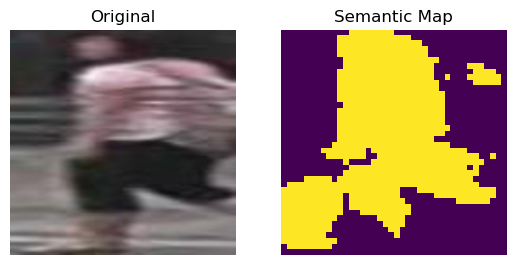

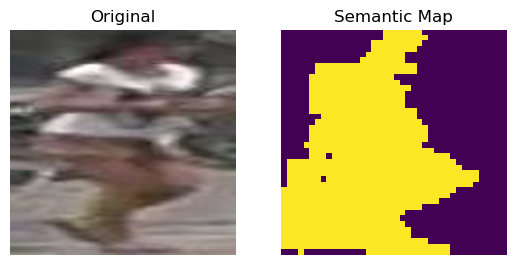

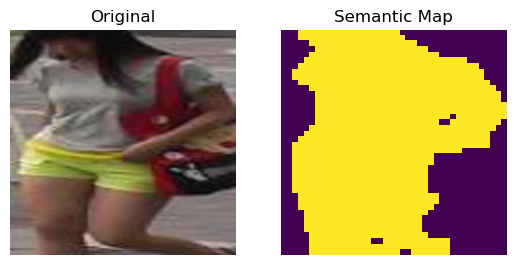

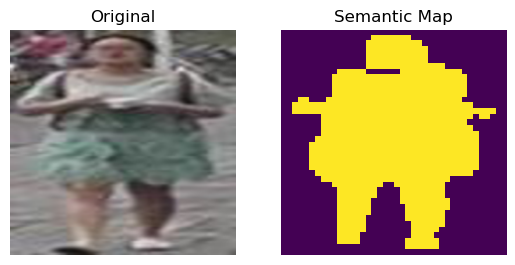

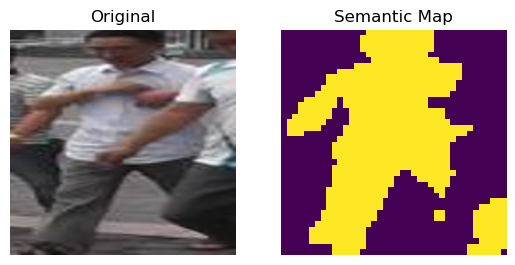

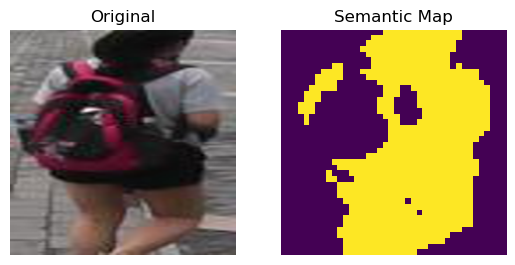

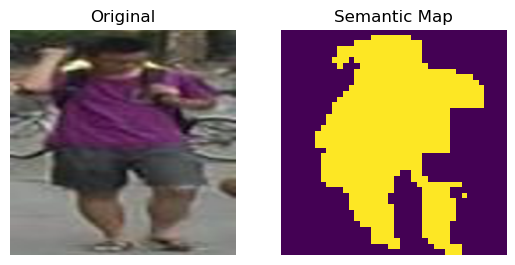

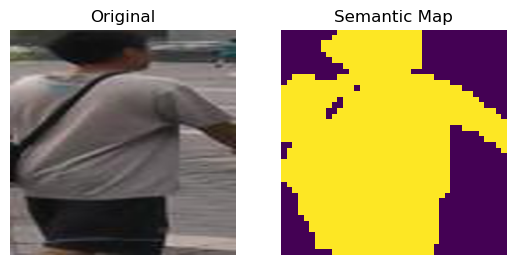

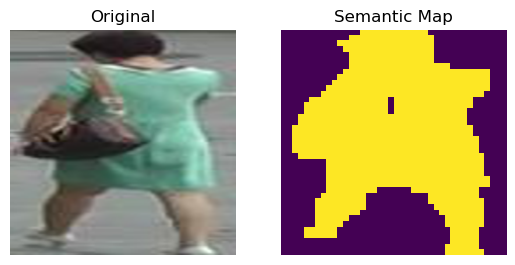

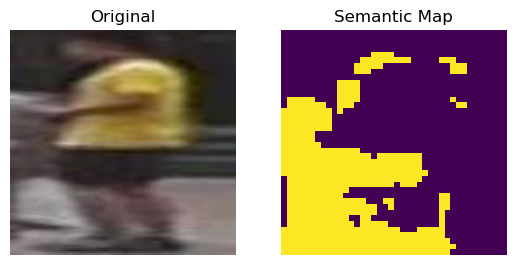

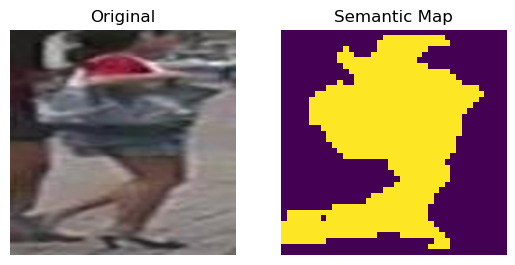

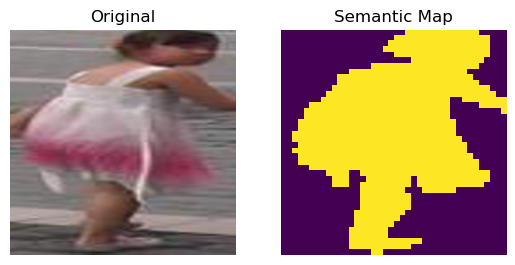

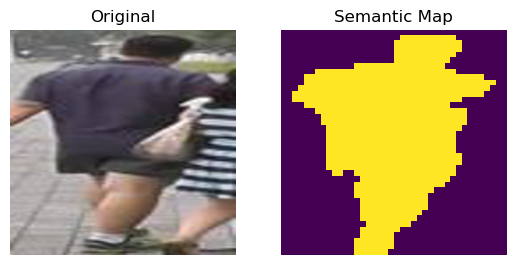

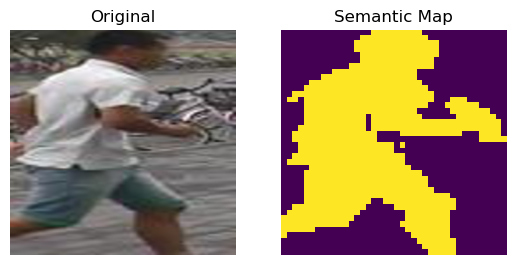

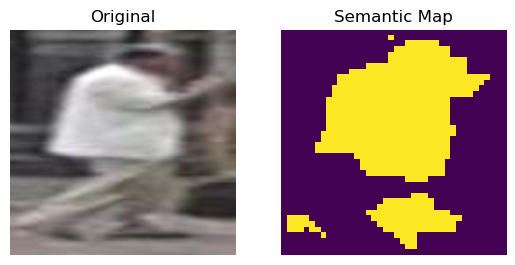

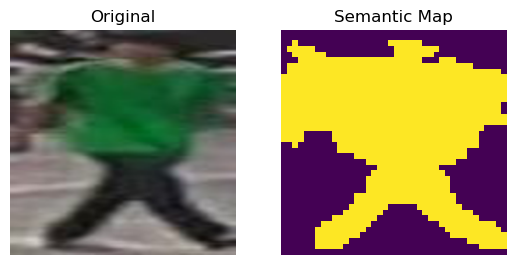

In [35]:
def transform_pred(pred):
    inference_transform = transforms.Compose([
            transforms.Resize((40, 40), 3),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ])
    colormap = [(0, 0, 0), [1, 1, 1]]
    cmap = matplotlib.colors.ListedColormap(colormap)
    bounds = [0, 1]
    norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
    
    pred = pred.squeeze(dim=0)        
    pred = pred.cpu().detach().numpy().transpose(1, 2, 0)
    pred = np.asarray(np.argmax(pred, axis=2), dtype=np.uint8).reshape((40, 40, 1))
    return pred
inference_transform = transforms.Compose([
            transforms.Resize((224, 224), 3),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ])


imgs, label = next(iter((dataloaders['val'])))
model = model.to('cpu')
preds = model(imgs)
preds = preds.unsqueeze(1)

for id in range(len(preds)):
    img = imgs[id]
    #img = denormalize(img.cpu().numpy(), [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    img = img.cpu().numpy()
    img = img.transpose(1, 2, 0).reshape((224, 224, 3))
    pred = transform_pred(preds[id])
    fig, ax = plt.subplots(nrows = 1, ncols=2)
    ax[0].imshow(img)
    ax[0].set_title(f'Original')
    ax[0].axis(False)
    
    # Transform and plot target image
    ax[1].imshow(pred)
    ax[1].set_title(f'Semantic Map')
    ax[1].axis(False)

In [3]:
models = {
    'squeezenet': lambda: PSPNet(sizes=(1, 2, 3, 6), psp_size=512, deep_features_size=256, backend='squeezenet'),
    'densenet': lambda: PSPNet(sizes=(1, 2, 3, 6), psp_size=1024, deep_features_size=512, backend='densenet'),
    'resnet18': lambda: PSPNet(sizes=(1, 2, 3, 6), psp_size=512, deep_features_size=256, backend='resnet18'),
    'resnet34': lambda: PSPNet(sizes=(1, 2, 3, 6), psp_size=512, deep_features_size=256, backend='resnet34'),
    'resnet50': lambda: PSPNet(sizes=(1, 2, 3, 6), psp_size=2048, deep_features_size=1024, backend='resnet50'),
    'resnet101': lambda: PSPNet(sizes=(1, 2, 3, 6), psp_size=2048, deep_features_size=1024, backend='resnet101'),
    'resnet152': lambda: PSPNet(sizes=(1, 2, 3, 6), psp_size=2048, deep_features_size=1024, backend='resnet152')
}

parser = argparse.ArgumentParser(description="Human Parsing")
parser.add_argument('--data_path', type=str, default='/home/jun/HumanSemanticDataset/myLIP')
parser.add_argument('--backend', type=str, default='densenet', help='Feature extractor')
parser.add_argument('--snapshot', type=str, default=None, help='Path to pre-trained weights')
parser.add_argument('--batch_size', type=int, default=16, help="Number of images sent to the network in one step.")
parser.add_argument('--epochs', type=int, default=20, help='Number of training epochs to run')
parser.add_argument('--crop_x', type=int, default=256, help='Horizontal random crop size')
parser.add_argument('--crop_y', type=int, default=256, help='Vertical random crop size')
parser.add_argument('--alpha', type=float, default=1.0, help='Coefficient for classification loss term')
parser.add_argument('--start_lr', type=float, default=0.001, help='Learning rate')
parser.add_argument('--milestones', type=str, default='10,20,30', help='Milestones for LR decreasing')
args = parser.parse_args([])

<class 'torch.Tensor'>


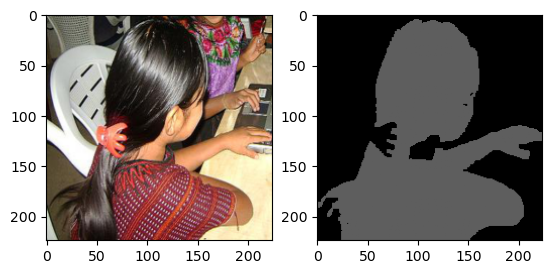

(224, 224, 3)
<class 'torch.Tensor'>


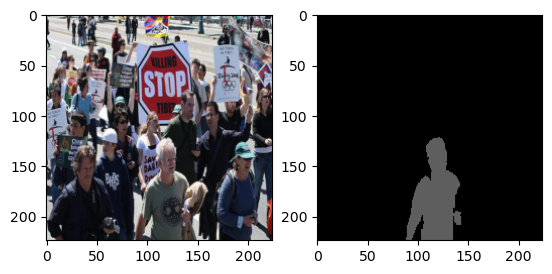

(224, 224, 3)
<class 'torch.Tensor'>


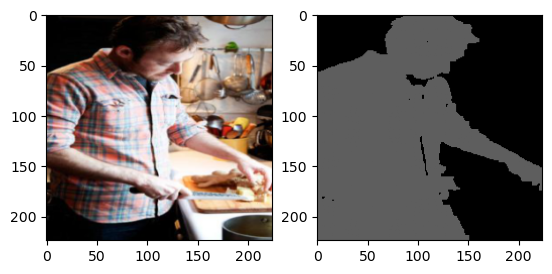

(224, 224, 3)
<class 'torch.Tensor'>


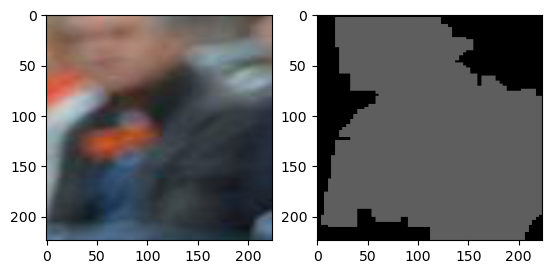

(224, 224, 3)


In [4]:
import matplotlib.pyplot as plt

path = '/home/jun/HumanSemanticDataset/myLIP'

transform_image_list = [
    transforms.Resize((224, 224), Image.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
]

transform_gt_list = [
    transforms.Resize((224, 224), Image.NEAREST),
    transforms.Lambda(lambda image: Image.fromarray(np.uint8(np.asarray(image)*(255.0/19.0)))),
    transforms.ToTensor(),
]

data_transforms = {
    'image': transforms.Compose(transform_image_list),
    'gt': transforms.Compose(transform_gt_list),
}

loader = data.DataLoader(LIP_Binary(path, transform=data_transforms['image'], gt_transform=data_transforms['gt']),
                         batch_size=32, shuffle=False)

for count, (src, lab) in enumerate(loader):
    print(type(lab))
    src = src[1, :, :, :].numpy()
    lab = lab[1, :, :, :].numpy().transpose(1, 2, 0)
    

    def denormalize(image, mean, std):
        c, _, _ = image.shape
        for idx in range(c):
            image[idx, :, :] = image[idx, :, :] * std[idx] + mean[idx]
        return image

    src = denormalize(src, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]).transpose(1, 2, 0)

    plt.subplot(121)
    plt.imshow(src)
    plt.subplot(122)
    plt.imshow(np.concatenate([lab, lab, lab], axis=2), cmap='gray')
    plt.show()
    print(src.shape)
    if count+1 == 4:
        break

In [6]:
def get_transform():
    transform_image_list = [
        transforms.Resize((224, 224), 3),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]

    transform_gt_list = [
        transforms.Resize((224, 224), 0),
        transforms.Lambda(lambda img: np.asarray(img, dtype=np.uint8)),
    ]

    data_transforms = {
        'img': transforms.Compose(transform_image_list),
        'gt': transforms.Compose(transform_gt_list),
    }
    return data_transforms

data_transform = get_transform()
train_loader = DataLoader(LIPWithClass_Binary(root=args.data_path, transform=data_transform['img'],
                                        gt_transform=data_transform['gt']),
                            batch_size=args.batch_size,
                            shuffle=True,
                            )

/home/jun/miniconda3/envs/py311/lib/python3.11/site-packages/torch/utils/data/_utils/collate.py:171: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /opt/conda/conda-bld/pytorch_1699449201450/work/torch/csrc/utils/tensor_numpy.cpp:206.)
  return collate([torch.as_tensor(b) for b in batch], collate_fn_map=collate_fn_map)


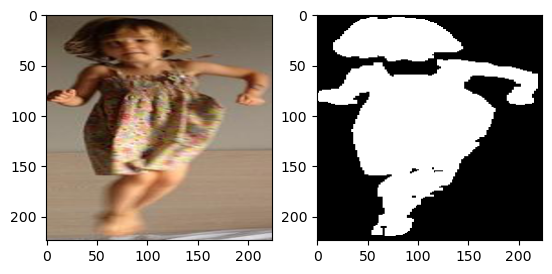

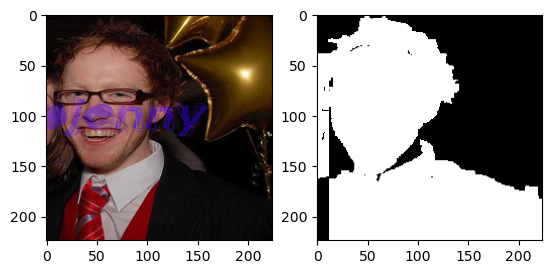

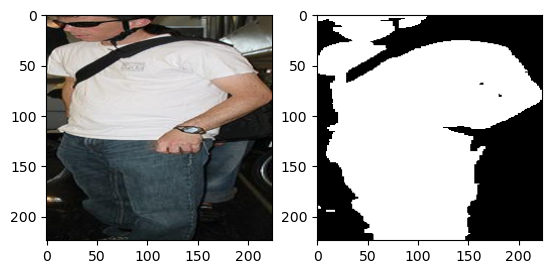

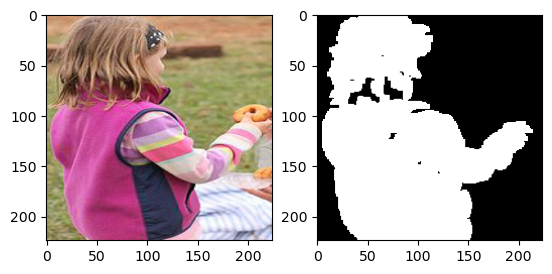

In [7]:
for count, (src, lab, cls) in enumerate(train_loader):
    src = src[1, :, :, :].numpy()
    lab = lab[1].numpy()
    def denormalize(image, mean, std):
        c, _, _ = image.shape
        for idx in range(c):
            image[idx, :, :] = image[idx, :, :] * std[idx] + mean[idx]
        return image

    src = denormalize(src, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]).transpose(1, 2, 0)

    plt.subplot(121)
    plt.imshow(src)
    plt.subplot(122)
    plt.imshow(lab, cmap='gray')
    plt.show()
    if count+1 == 4:
        break

In [6]:
device = 'cuda'
model = PSPNet(sizes=(1, 2, 3, 6), psp_size=1024, deep_features_size=512, backend='densenet').to(device)

/home/jun/miniconda3/envs/py311/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/jun/miniconda3/envs/py311/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [8]:
optimizer = optim.Adam(model.parameters(), lr=args.start_lr)
scheduler = MultiStepLR(optimizer, milestones=[int(x) for x in args.milestones.split(',')])
seg_criterion = nn.NLLLoss()
cls_criterion = nn.BCEWithLogitsLoss()
for epoch in range(1, 1+20):
    epoch_losses = []
    model.train()

    for count, (x, y, y_cls) in enumerate(train_loader):
        # input data
        x, y, y_cls = x.to(device), y.to(device).long(), y_cls.to(device).float()
        # forward
        out, out_cls = model(x)
        #cls_loss = cls_criterion(out_cls, y_cls) 
        #seg_loss = seg_criterion(out, y)
        #print(y)
        seg_loss, cls_loss = seg_criterion(out, y), cls_criterion(out_cls, y_cls)
        #loss = seg_loss + args.alpha * cls_loss
        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # print
        #epoch_losses.append(loss.item())
        #status = '[{0}] step = {1}/{2}, loss = {3:0.4f} avg = {4:0.4f}, LR = {5:0.7f}'.format(
        #    epoch, count, len(train_loader),
        #    loss.item(), np.mean(epoch_losses), scheduler.get_lr()[0])
        #print(status)

    scheduler.step()
    if epoch % 10 == 0:
        torch.save(model.state_dict(), os.path.join(model, '_'.join(["PSPNet", str(epoch)])))

torch.save(model.state_dict(), os.path.join(model, '_'.join(["PSPNet", 'last'])))

KeyboardInterrupt: 